<a href="https://colab.research.google.com/github/gopichandchalla16/infosys-internship-real-time-industry-insight-system/blob/main/Project_Sprint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Infosys Springboard Internship Project
## Real-Time Industry Insight & Strategic Intelligence System
### Sprint 1 – Data Sourcing & Handling
**Team Members:** Gopichand, Anshika, Janmejay, Vaishnavi

**Objective:** Collect, clean, and visualize real-time company or market data from external open sources.


## Step 1: Interactive User Input
We allow users to enter a **company or asset name** to fetch relevant data dynamically.


In [55]:
# User input for asset/company
asset_name = input("Enter the company name (e.g.TCS, Rakuten, Netflix): ").upper()
print(f"\nData analysis will be performed for: {asset_name}")


Enter the company name (e.g.TCS, Rakuten, Netflix): Netflix

Data analysis will be performed for: NETFLIX


##  Step 2: Import Required Libraries
We use the following Python libraries:
- `requests` & `BeautifulSoup` for scraping web data
- `pandas` for data manipulation
- `matplotlib` & `seaborn` for visualization
- `textblob` for sentiment analysis
- `yfinance` for market data
- `wikipedia` for Wikipedia summaries


In [56]:
# Install required libraries (run once)
!pip install yfinance textblob beautifulsoup4 lxml wikipedia feedparser faker
!pip install yfinance wikipedia beautifulsoup4 lxml feedparser transformers sentencepiece torch --quiet
!pip install tensorflow statsmodels --quiet
!pip install ipywidgets --quiet

# Import libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import yfinance as yf
import wikipedia
from bs4 import BeautifulSoup
import feedparser
from faker import Faker
import random
import datetime
import urllib.parse
from IPython.display import display, HTML, Image, clear_output
import base64


from google.colab import output
output.enable_custom_widget_manager()

# Set seaborn style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

### Using Hugging Face’s **Transformers library** to perform sentiment analysis  with a pretrained model.

In [57]:
# HuggingFace sentiment
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

## Step 3: Fetch Wikipedia Summary
We fetch a **short summary** of the asset/company from Wikipedia for context.


In [58]:
def get_company_summary(company_name):
    try:
        # Search Wikipedia for the company
        search_results = wikipedia.search(company_name)

        if not search_results:
            return f"No Wikipedia pages found for {company_name}"

        # Keywords to detect company pages
        company_keywords = ["company", "corporation", "limited", "ltd", "group", "services", "bank", "motor", "industries", "technology"]
        global company_summary;
        # Try to find the best company-related page
        best_match = None
        for result in search_results:
            lower = result.lower()
            if any(keyword in lower for keyword in company_keywords):
                best_match = result
                break

        # If no match found, pick the first result
        if not best_match:
            best_match = search_results[0]

        # Fetch summary
        company_summary = wikipedia.summary(best_match, sentences=10)
        return company_summary

    except wikipedia.exceptions.DisambiguationError as e:
        # Pick first meaningful option
        option = e.options[0]
        company_summary = wikipedia.summary(option, sentences=10)
        return company_summary

    except Exception as e:
        return f"Error fetching summary: {e}"

# Usage:
print(get_company_summary(asset_name))


Netflix is an American subscription video on-demand over-the-top streaming service. The service primarily distributes original and acquired films and television shows from various genres, and it is available internationally in multiple languages.
Launched in 2007, nearly a decade after Netflix, Inc. began its pioneering DVD-by-mail movie rental service, Netflix is the most-subscribed video on demand streaming media service, with 301.6 million paid memberships in more than 190 countries as of 2025. By 2022, "Netflix Original" productions accounted for half of its library in the United States and the namesake company had ventured into other categories, such as video game publishing of mobile games through its flagship service. As of 2025, Netflix is the 18th most-visited website in the world, with 21.18% of its traffic coming from the United States, followed by the United Kingdom at 6.01%, Canada at 4.94%, and Brazil at 4.24%.


== History ==


=== Launch as a mail-based rental business 

## Step 4: Fetch Yahoo Finance Data
We fetch **historical market data** (last 30 days) for the asset using Yahoo Finance.

In [59]:
tickers = {
    # Existing
    "NETFLIX": "NFLX",
    "APPLE": "AAPL",
    "TESLA": "TSLA",
    "GOOGLE": "GOOGL",
    "MICROSOFT": "MSFT",
    "TCS": "TCS.NS",
    "INFOSYS": "INFY.NS",
    "RAKUTEN": "RKUNY",
    "BITCOIN": "BTC-USD",

    # 🔥 Popular US Tech
    "AMAZON": "AMZN",
    "META": "META",         # Facebook
    "NVIDIA": "NVDA",
    "AMD": "AMD",
    "INTEL": "INTC",

    # 🏦 Finance
    "JP MORGAN": "JPM",
    "GOLDMAN SACHS": "GS",
    "MASTERCARD": "MA",
    "VISA": "V",

    # 🇮🇳 Common Indian Stocks
    "RELIANCE": "RELIANCE.NS",
    "HDFC": "HDFCBANK.NS",
    "ICICI": "ICICIBANK.NS",
    "WIPRO": "WIPRO.NS",
    "HCL": "HCLTECH.NS",
    "ADANIPORTS": "ADANIPORTS.NS",
    "ADANIENT": "ADANIENT.NS",

    # 🚗 Auto
    "TATA MOTORS": "TATAMOTORS.NS",
    "MARUTI": "MARUTI.NS",
    "TESLA": "TSLA",       # already above but kept for auto category

    # 🔴 Other Big Names
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",
    "NETFLIX": "NFLX",     # already included

    # 💰 Other popular crypto
    "ETHEREUM": "ETH-USD",
    "DOGECOIN": "DOGE-USD",
    "SOLANA": "SOL-USD"
}

try:
    asset = tickers.get(asset_name.upper(), asset_name.upper())
    ticker = yf.Ticker(asset)
    market_data = ticker.history(period="1mo", interval="1d")

    if market_data.empty:
        raise ValueError("No data returned. Check ticker symbol.")

    market_data.reset_index(inplace=True)
    print(f"\n Market Data Sample for {asset}:")
    display(market_data.head())

except Exception as e:
    print(f"Could not fetch Yahoo Finance data: {e}")



 Market Data Sample for NFLX:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-10-13 00:00:00-04:00,1221.349976,1231.119995,1206.810059,1219.030029,2460800,0.0,0.0
1,2025-10-14 00:00:00-04:00,1214.750000,1224.290039,1203.099976,1215.349976,2362400,0.0,0.0
2,2025-10-15 00:00:00-04:00,1213.010010,1219.619995,1201.609985,1203.290039,2025200,0.0,0.0
3,2025-10-16 00:00:00-04:00,1212.150024,1216.709961,1176.000000,1183.589966,2832600,0.0,0.0
4,2025-10-17 00:00:00-04:00,1183.599976,1203.119995,1178.949951,1199.359985,2957100,0.0,0.0


In [60]:
from IPython.display import display, HTML
import feedparser

# Construct RSS feed URL for Google News
news_url = f"https://news.google.com/rss/search?q={asset_name}&hl=en-US&gl=US&ceid=US:en"

feed = feedparser.parse(news_url)

print(f"\n Recent News Headlines for {asset_name}:")

# Iterate through the first 10 news items (or fewer if less than 10)
for entry in feed.entries[:10]:
    display(HTML(f'{entry.title}'))
    # Display summary and source if available
    news_summary = getattr(entry, 'summary', 'N/A')
    source = getattr(entry, 'source', 'N/A')
    print(f"Summary: {news_summary}\nSource: {source.get('title', 'N/A')}\n")


 Recent News Headlines for NETFLIX:


Summary: <ol><li><a href="https://news.google.com/rss/articles/CBMie0FVX3lxTE4tU09QczNOYnE4MjF6Z2RDTkhtNklWLXJabjZ6WXRZLXlMeTUtM2RjUEVIOVlSeEFZNXdLeF92MHhnczljSy15WDRqaUptOWdOaWRBd1BlVnA2TlJ4TWRWSV9nZm1aUC13c1VzMXpFdGdIOGJ0bFBIbUJDVQ?oc=5" target="_blank">The first 'Netflix House' is open — with virtual reality, mini-golf and lots of selfies</a>&nbsp;&nbsp;<font color="#6f6f6f">NPR</font></li><li><a href="https://news.google.com/rss/articles/CBMixgFBVV95cUxQUWxtTXlLR1Fta2NvUlJ0eXU0NWtHMDRPNHRtYVNOaXIwcG1JNUF3RTRWMVdqOENVVkhaeVRtYXRlNVI3LXhoTERyVUdkVjB0a0JGa3VacHBBWTVOd28xaW90azJnNUFtZlRSb0FKd1J1MndpaDhoZGFCRzVZZkRTMk5adDVsVzU5NWJQUmRXLU5Ca3dlREIwcGR5dTBnQXlrRHJUd1ZoUjl4NUNOOWJ6M1diLTdxVmRReGlRdXBJeWc1SWdqSEE?oc=5" target="_blank">Inside Netflix House: A Big Bet On Experiential Entertainment</a>&nbsp;&nbsp;<font color="#6f6f6f">The Hollywood Reporter</font></li><li><a href="https://news.google.com/rss/articles/CBMirwFBVV95cUxQSTJPcjFveTRFNjhMei1uN240MDIyS2VteFRURlBCdHZoaXIyWlJCWEdvUXFQN

Summary: <a href="https://news.google.com/rss/articles/CBMilgFBVV95cUxPb1hNMFd1eTY1MkZKQzRPc1UtOVdIRXFWVzJMN1M0MWRmSWpXbTl0MmdOWjl0cVRUVTVJQllOZDNFNkFpY0lESU5JLW50U2NtSmoza3ZiSTNBOHdlM2ltd3ZTN2JqTXYzRU9GNWJ4OS1IdzNJdk5jSGRLZzRwcE52YjNvNlpYbmVJWm9FWnpFT3ZsMndGNnc?oc=5" target="_blank">Howard Gordon Talks 'The Beast In Me', Potential '24' Revival: Q&amp;A</a>&nbsp;&nbsp;<font color="#6f6f6f">Deadline</font>
Source: Deadline



Summary: <a href="https://news.google.com/rss/articles/CBMibEFVX3lxTE5fWW42aXRnQVRhQ2l6NWVJS2M0ZzBDYUtVXzJYRWV0Nktwc2JfRjhPT0NoU3B3VVc4dkpKeFlEOVotNDM3Y0kyUXhycldiNmVPeUNmNTNIX2tNOXhxYTJGM05sMUVxSmNNZThaSg?oc=5" target="_blank">Netflix’s The Beast in Me Review</a>&nbsp;&nbsp;<font color="#6f6f6f">IGN</font>
Source: IGN



Summary: <a href="https://news.google.com/rss/articles/CBMitwFBVV95cUxOcWxoM21NN1dtcF9GRUdRMGNNb3haTVNBeEJFZHYwZ0VFOHpWcXVIMThQdjJQbEdEQzl5dFlCcVF5N2lNdGd5Rk1GU3hqaWN0UXVLZDBIeTdXNy1qbG1BSXdGRnlnY2hiTkFJeUpobXB0OFNTNjI2SFBUX3A4X2gzTmtmZU4tWjVsWjdTeUhLa05nMHVMWkpyTXNEcXFkMWw4UVV1bjVMbkdRMGZyZDk2TU1HaFhXbFE?oc=5" target="_blank">‘The Beast in Me’ Review: Claire Danes and Matthew Rhys Try Hard, but Netflix’s Cat-and-Mouse Thriller Is an Exercise in Prestige TV Monotony</a>&nbsp;&nbsp;<font color="#6f6f6f">The Hollywood Reporter</font>
Source: The Hollywood Reporter



Summary: <a href="https://news.google.com/rss/articles/CBMihAFBVV95cUxObnRhbHd4eGdoYkxCQUFqQkUybERTNDA4eGsxMlk1Q2tYMWtHaDRMeXlIRng5bFZ6eEdzVlllWTMtSEMzMlFoTS1kMGFGMVl2dEYxb04wM2J1clZWR0tuZ0RkVzhRTTgtNTJ5Mmdmb3hIM19odDdVTTNkOGIyem9aeGdtbVE?oc=5" target="_blank">Netflix Pops on Long-Anticipated 10-for-1 Stock Split: Why This Growth Stock Is a Great Buy in November</a>&nbsp;&nbsp;<font color="#6f6f6f">Yahoo Finance</font>
Source: Yahoo Finance



Summary: <a href="https://news.google.com/rss/articles/CBMixAFBVV95cUxOQ2FaYUJtMkctZm5DWGNmUWJ6c2JiaGNxTEt6QTRQX3hIWGpEb0U0ak1veUJtd0I5cnZCSVlIT21QN0VJVGd2d1FVRm1wVFFCUnZrMnFlWkxPcXhyYzNoRHUtMERmNWFlTnMyQk9wbWZKQnhmMmI1SzBDaUMzUmF5RjAzRUpxZ0FWVEJvbWh3TGxVaWNrN3IzUXlRVE5mcXU3T1R4SGtnSjF4bG41OTFfRThwc3IzWjNOaENJbDZyMndLMlIz?oc=5" target="_blank">There have been 79 new Netflix shows in 2025 so far — here’s the 7 worth watching</a>&nbsp;&nbsp;<font color="#6f6f6f">Tom's Guide</font>
Source: Tom's Guide



Summary: <a href="https://news.google.com/rss/articles/CBMiowFBVV95cUxPanFoR3kwUzU5dlFZaU5vd1dhRWNNSXhSRzROY2g2WVdSVXFCcTZQVGg0UXUtLWxxa01CY3NfMVZiUF8tT2tqVzJ2VkJTQ1JIMVVOV2FGaEZVdGpWMkFLMDhQbThHOVNGUkFIRjR5OEIzdkNsXy14dTRNbkc4cnF1MjFJQkttcUdHU1RGV1FWWXQ3ekNNR1Z1a19qWUVWdWhPVkxr?oc=5" target="_blank">'Being Eddie' lifts the veil on one of America's top comedians: 9 takeaways from the documentary</a>&nbsp;&nbsp;<font color="#6f6f6f">Los Angeles Times</font>
Source: Los Angeles Times



Summary: <a href="https://news.google.com/rss/articles/CBMiugFBVV95cUxNT1IxTHZfTHB5LWxBZTV2eFBqS0NvNkNHODVUT2FOeXVHT1JpWDBWVjZQNUYtUUxJVGRaVmZ4dG4xTHVJTEd5U3lCNDdwa3U4RDNJek1jT1NTQU0wdk9tZTJfcUU1NFRRcWE0ck9HY3lTanRUOTU0bWl6U3hWOHRmTVU3QlpMbFQyTm5HY1ZTenhHMEZHVlZWRGFJTG03ZzBmVWV0akNTTnZKa3RZTDRjdlpreW9GYjZFX1E?oc=5" target="_blank">Eddie Murphy on His Netflix Doc, ‘Shrek 5,’ Resolving Feuds and That Elusive Oscar</a>&nbsp;&nbsp;<font color="#6f6f6f">The Hollywood Reporter</font>
Source: The Hollywood Reporter



Summary: <a href="https://news.google.com/rss/articles/CBMiigFBVV95cUxPblJsTlY1dkpLYnZ4UmJqM1NwbkZjbDBBcnRvcWZvWHVoZGpoeGItVXg3d2JZZ0kzUnlFMXc0RUZnTEp1dTYtNTRUODhGUF9sZ25OSGlpU0ZMaHhHS1o1NGJYeXF0MXRQUnlCeFlnRHYwRFpiTnFYUXIxTXd0cExVNzZfNmJCLVV5UUE?oc=5" target="_blank">Being Eddie review – reverential Netflix doc paints limited portrait of Eddie Murphy</a>&nbsp;&nbsp;<font color="#6f6f6f">The Guardian</font>
Source: The Guardian



Summary: <a href="https://news.google.com/rss/articles/CBMitgFBVV95cUxOamZNTkdMblV2V3V2c2lWVXEwcHBXYzNSNWd5OHE3QXBicl92NjYzY1B5X216M1ZZcS03WHRNa3NTdmdEaFlrQ3NfaW56aHpXYkJGd2x5VUZRX29ZZkZRWVhLNmd1R2ktVUtVQm04WXJkYnF1SHRYYklMTmNEZUVJNEowZTI3QktXYmZkX0VrNU5NRENqMmYxc2pzTXphbEdNODdkV1BVX1R0SWMxUWk1ZVM0SmV6Zw?oc=5" target="_blank">'Sesame Street' on Netflix has these big changes</a>&nbsp;&nbsp;<font color="#6f6f6f">USA Today</font>
Source: USA Today



## Step 5: Fetch Google News Headlines via RSS
We fetch **recent news headlines** about the asset using Google News RSS.


In [61]:
# Construct RSS feed URL for Google News
company_name=asset_name.replace(" ", "");
rss_url = f"https://news.google.com/rss/search?q={company_name}&hl=en-US&gl=US&ceid=US:en"
global news_items
feed = feedparser.parse(rss_url)
news_items = [{"Title": entry.title, "Link": entry.link, "Published": entry.published} for entry in feed.entries[:10]]
titles = [item["Title"] for item in news_items]
links = [item["Link"] for item in news_items]
news_df = pd.DataFrame(news_items)
print(f"\n Top 10 News Headlines for {asset_name}:")
display(news_df)


 Top 10 News Headlines for NETFLIX:


,Title,Link,Published
0,The first 'Netflix House' is open — with virtu...,https://news.google.com/rss/articles/CBMie0FVX...,"Wed, 12 Nov 2025 10:00:00 GMT"
1,"Howard Gordon Talks 'The Beast In Me', Potenti...",https://news.google.com/rss/articles/CBMilgFBV...,"Wed, 12 Nov 2025 22:35:00 GMT"
2,Netflix’s The Beast in Me Review - IGN,https://news.google.com/rss/articles/CBMibEFVX...,"Thu, 13 Nov 2025 08:03:11 GMT"
3,‘The Beast in Me’ Review: Claire Danes and Mat...,https://news.google.com/rss/articles/CBMitwFBV...,"Thu, 13 Nov 2025 08:01:39 GMT"
4,Netflix Pops on Long-Anticipated 10-for-1 Stoc...,https://news.google.com/rss/articles/CBMihAFBV...,"Thu, 13 Nov 2025 08:02:00 GMT"
5,There have been 79 new Netflix shows in 2025 s...,https://news.google.com/rss/articles/CBMixAFBV...,"Wed, 12 Nov 2025 05:01:00 GMT"
6,'Being Eddie' lifts the veil on one of America...,https://news.google.com/rss/articles/CBMiowFBV...,"Wed, 12 Nov 2025 08:01:00 GMT"
7,"Eddie Murphy on His Netflix Doc, ‘Shrek 5,’ Re...",https://news.google.com/rss/articles/CBMiugFBV...,"Wed, 12 Nov 2025 14:45:27 GMT"
8,Being Eddie review – reverential Netflix doc p...,https://news.google.com/rss/articles/CBMiigFBV...,"Wed, 12 Nov 2025 09:04:00 GMT"
9,'Sesame Street' on Netflix has these big chang...,https://news.google.com/rss/articles/CBMitgFBV...,"Wed, 12 Nov 2025 15:06:36 GMT"


## Step 6: Generate Synthetic Tweets
We generate **50 realistic tweets** using `Faker` and random sentiment phrases for demonstration.


In [62]:
from faker import Faker
import random
import pandas as pd

fake = Faker()

# Fix: properly close the list after 'else'
texts = [n["Title"] for n in news_items] if news_items else [
    fake.sentence(nb_words=6) for _ in range(10)
]

positive_phrases = [
    f"{company_name} is surging!",
    f"Profits from {company_name} are amazing!",
    f"Holding {company_name} long-term, confident.",
    f"{company_name} adoption is growing worldwide!",
    f"Investors are optimistic about {company_name}."
]

negative_phrases = [
    f"Worried about {company_name} volatility.",
    f"{company_name} might crash soon.",
    f"{company_name}'s future is uncertain.",
    f"High risks in {company_name} investments.",
    f"{company_name} energy consumption is concerning."
]

neutral_phrases = [
    f"{company_name} price remains stable today.",
    f"Market watching {company_name} closely.",
    f"{company_name} updates coming soon.",
    f"{company_name} performance unchanged.",
    f"Analysts report on {company_name} today."
]

tweets = []
for _ in range(50):
    sentiment_choice = random.choices(
        ["positive", "negative", "neutral"], weights=[0.4, 0.3, 0.3]
    )[0]
    if sentiment_choice == "positive":
        tweets.append(random.choice(positive_phrases))
    elif sentiment_choice == "negative":
        tweets.append(random.choice(negative_phrases))
    else:
        tweets.append(random.choice(neutral_phrases))

tweets_df = pd.DataFrame(tweets, columns=["Tweet"])

# Display output based on the data source used
if news_items:
    print(f"\nPerforming sentiment analysis on {len(texts)} news items:\n")
    for i, text in enumerate(texts, 1):
        print(f"{i}. {text}")
else:
    print(f"\nPerforming sentiment analysis on {len(tweets_df)} generated tweets:\n")
    print(tweets_df)



Performing sentiment analysis on 10 news items:

1. The first 'Netflix House' is open — with virtual reality, mini-golf and lots of selfies - NPR
2. Howard Gordon Talks 'The Beast In Me', Potential '24' Revival: Q&A - Deadline
3. Netflix’s The Beast in Me Review - IGN
4. ‘The Beast in Me’ Review: Claire Danes and Matthew Rhys Try Hard, but Netflix’s Cat-and-Mouse Thriller Is an Exercise in Prestige TV Monotony - The Hollywood Reporter
5. Netflix Pops on Long-Anticipated 10-for-1 Stock Split: Why This Growth Stock Is a Great Buy in November - Yahoo Finance
6. There have been 79 new Netflix shows in 2025 so far — here’s the 7 worth watching - Tom's Guide
7. 'Being Eddie' lifts the veil on one of America's top comedians: 9 takeaways from the documentary - Los Angeles Times
8. Eddie Murphy on His Netflix Doc, ‘Shrek 5,’ Resolving Feuds and That Elusive Oscar - The Hollywood Reporter
9. Being Eddie review – reverential Netflix doc paints limited portrait of Eddie Murphy - The Guardian
10. 

## Step 7: Preprocess Tweets & Perform Sentiment Analysis
We analyze the **polarity** of each tweet using `ProsusAI/finbert model` and classify them into Positive, Negative, or Neutral.


In [63]:
# Financial NLP model

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ["Negative", "Neutral", "Positive"]



def finbert_sentiment(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        out = hf_model(**tokens)
    probs = torch.softmax(out.logits, dim=1).cpu().numpy()[0]
    sentiment = labels[int(np.argmax(probs))]
    return sentiment, probs

# ✅ Generate sentiment rows
sent_rows = []
for t in texts:
    s_label, s_probs = finbert_sentiment(t)
    sent_rows.append({
        "text": t,
        "sentiment": s_label,
        "neg": float(s_probs[0]),
        "neu": float(s_probs[1]),
        "pos": float(s_probs[2]),
    })

# ✅ Final Sentiment DataFrame
sent_df = pd.DataFrame(sent_rows)
# display(sent_df)

# ----- DARK MODE SENTIMENT TABLE UI -----

def color_row(sentiment):
    if sentiment == "Positive":
        return "background:rgba(0,255,150,0.18); border-left:4px solid #00ff88;"
    elif sentiment == "Negative":
        return "background:rgba(255,0,80,0.18); border-left:4px solid #ff0055;"
    else:
        return "background:rgba(255,255,255,0.10); border-left:4px solid #bbbbbb;"

html_rows = ""

for _, row in sent_df.iterrows():
    html_rows += f"""
        <tr style="{color_row(row['sentiment'])}; padding:10px;">
            <td style="padding:12px; color:#eee;">{row['text'][:120]}...</td>
            <td style="padding:12px; color:#00eaff; font-weight:600;">{row['sentiment']}</td>
            <td style="padding:12px; color:#ff6666;">{row['neg']:.2f}</td>
            <td style="padding:12px; color:#cccccc;">{row['neu']:.2f}</td>
            <td style="padding:12px; color:#00ff88;">{row['pos']:.2f}</td>
        </tr>
    """

sent_table_html = f"""
<div style="
    padding:20px;
    background:rgba(20,20,25,0.75);
    border-radius:18px;
    border:1px solid #333;
    box-shadow:0 0 30px rgba(0,255,255,0.15);
    color:white;
    font-family:Segoe UI;
    width:90%;
">
    <h2 style="color:#00eaff; margin-top:0;">🧠 HuggingFace Sentiment Analysis</h2>

    <table style="width:100%; border-collapse:collapse; font-size:15px;">
        <thead>
            <tr style="background:#111;">
                <th style="padding:12px; color:#00eaff; text-align:left;">Text</th>
                <th style="padding:12px; color:#00eaff; text-align:left;">Sentiment</th>
                <th style="padding:12px; color:#00eaff;">Neg</th>
                <th style="padding:12px; color:#00eaff;">Neu</th>
                <th style="padding:12px; color:#00eaff;">Pos</th>
            </tr>
        </thead>
        <tbody>
            {html_rows}
        </tbody>
    </table>
</div>
"""

display(HTML(sent_table_html))




Text,Sentiment,Neg,Neu,Pos
"The first 'Netflix House' is open — with virtual reality, mini-golf and lots of selfies - NPR...",Positive,0.06,0.01,0.93
"Howard Gordon Talks 'The Beast In Me', Potential '24' Revival: Q&A - Deadline...",Positive,0.17,0.01,0.81
Netflix’s The Beast in Me Review - IGN...,Positive,0.08,0.04,0.89
"‘The Beast in Me’ Review: Claire Danes and Matthew Rhys Try Hard, but Netflix’s Cat-and-Mouse Thriller Is an Exercise in...",Positive,0.04,0.08,0.88
Netflix Pops on Long-Anticipated 10-for-1 Stock Split: Why This Growth Stock Is a Great Buy in November - Yahoo Finance...,Positive,0.17,0.02,0.82
There have been 79 new Netflix shows in 2025 so far — here’s the 7 worth watching - Tom's Guide...,Positive,0.05,0.02,0.93
'Being Eddie' lifts the veil on one of America's top comedians: 9 takeaways from the documentary - Los Angeles Times...,Positive,0.11,0.04,0.85
"Eddie Murphy on His Netflix Doc, ‘Shrek 5,’ Resolving Feuds and That Elusive Oscar - The Hollywood Reporter...",Positive,0.15,0.07,0.78
Being Eddie review – reverential Netflix doc paints limited portrait of Eddie Murphy - The Guardian...,Positive,0.07,0.03,0.90
'Sesame Street' on Netflix has these big changes - USA Today...,Positive,0.05,0.02,0.93


## Step 8: Visualize Sentiment Distribution
We create a **bar chart** showing how many tweets fall into each sentiment category.

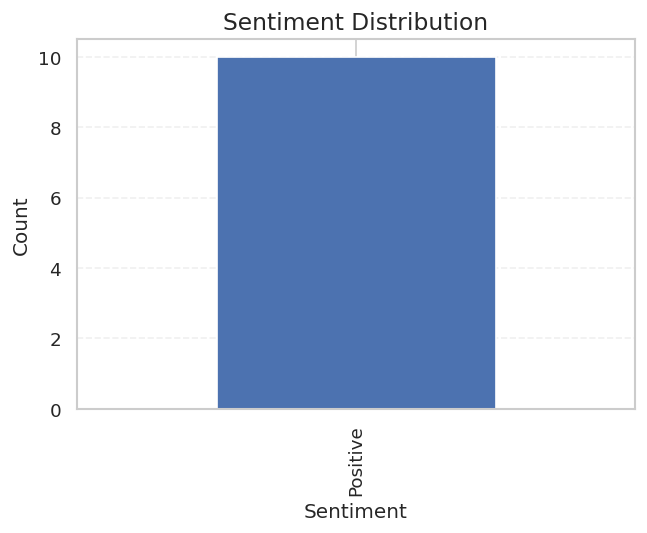

In [64]:
# plt.figure(figsize=(6,4))
# sns.countplot(data=tweets_df, x="Sentiment", hue="Sentiment", palette="viridis", legend=False)
# plt.title(f"Sentiment Distribution for {company_name} Tweets")
# plt.xlabel("Sentiment")
# plt.ylabel("Tweet Count")
# plt.show()

plt.figure(figsize=(6,4))
sent_df['sentiment'].value_counts().plot(kind='bar', edgecolor='white')
plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()




## Step 9: Visualize Sentiment Trend Across Tweets
We create a **line chart** showing polarity trend across the 50 tweets.


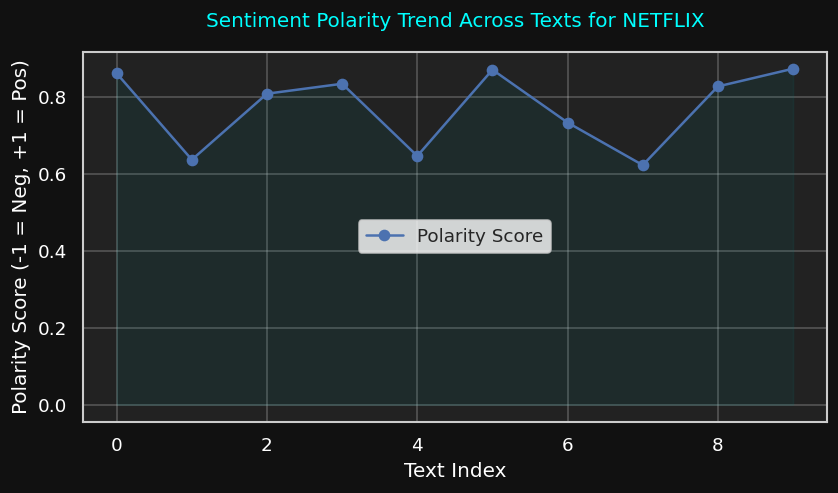

In [65]:
# plt.figure(figsize=(8,4))
# plt.plot(tweets_df.index, tweets_df["Polarity"], marker='o', linestyle='-', color='teal')
# plt.title(f"Sentiment Polarity Trend Across Tweets for {company_name}")
# plt.xlabel("Tweet Index")
# plt.ylabel("Polarity Score")
# plt.grid(True)
# plt.show()

sent_df["polarity_score"] = (
    sent_df["pos"] * 1 + sent_df["neu"] * 0 + sent_df["neg"] * -1
)
# Plot polarity trend
plt.figure(figsize=(8, 4))
plt.plot(
    range(len(sent_df)),
    sent_df["polarity_score"],
    marker="o",
    linestyle="-",
    label="Polarity Score"
)
plt.fill_between(
    range(len(sent_df)),
    sent_df["polarity_score"],
    color="teal",
    alpha=0.1
)

plt.title(f"Sentiment Polarity Trend Across Texts for {company_name}", color="cyan", pad=15)
plt.xlabel("Text Index", color="white")
plt.ylabel("Polarity Score (-1 = Neg, +1 = Pos)", color="white")
plt.grid(True, alpha=0.3)
plt.legend()
plt.gcf().patch.set_facecolor("#111")
plt.gca().set_facecolor("#222")
plt.tick_params(colors="white")
plt.show()


## Step 10: Visualize Market Price Trend
For context, we visualize the closing price of the asset over the last 30 days.


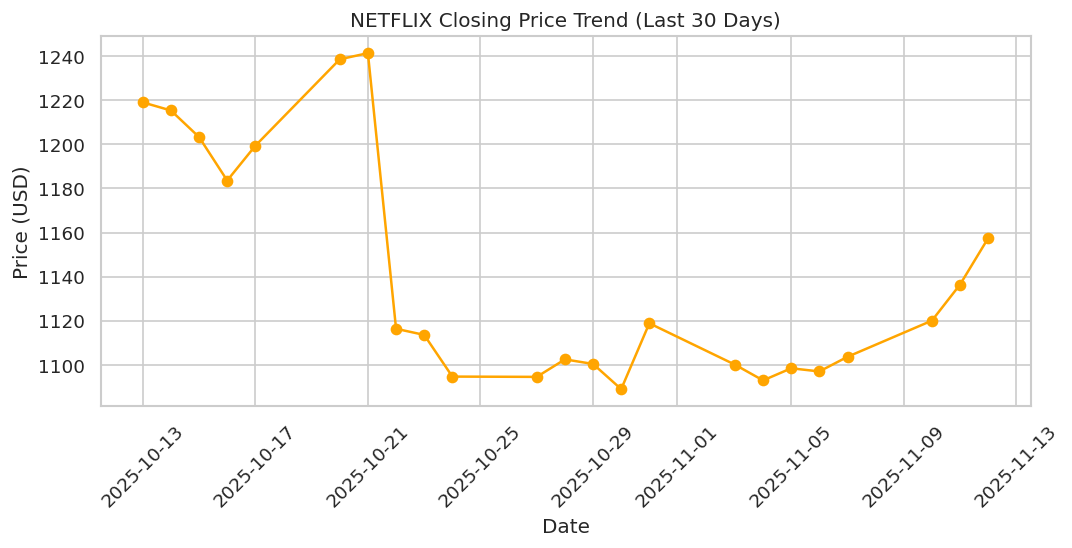

In [66]:
plt.figure(figsize=(10,4))
plt.plot(market_data["Date"], market_data["Close"], marker='o', color='orange')
plt.title(f"{company_name} Closing Price Trend (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Using Alpha Vantage for Stock Data


First, install the library:

In [67]:
!pip install alpha_vantage

### Analyze Alpha Vantage Data
Here are some descriptive statistics for the Alpha Vantage data:

In [68]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from google.colab import userdata

API_KEY = userdata.get('ALPHA_VANTAGE_API')
def detect_symbol(asset_name: str) -> str:
    """
    Maps common company/asset names to their typical stock or crypto symbols.
    If no match is found, the name itself is returned as the potential symbol.
    """
    mapping = {
    "BITCOIN": "BTCUSD",
    "BTC": "BTCUSD",

    "TESLA": "TSLA",
    "TSLA": "TSLA",

    "NETFLIX": "NFLX",
    "NFLX": "NFLX",

    "INFOSYS": "INFY",
    "INFY": "INFY",

    "TCS": "TCS",
    "TATA CONSULTANCY": "TCS",

    "RAKUTEN": "RKUNY",

    # ✅ Common U.S. tech
    "APPLE": "AAPL",
    "AAPL": "AAPL",

    "GOOGLE": "GOOG",
    "ALPHABET": "GOOG",
    "GOOG": "GOOG",

    "MICROSOFT": "MSFT",
    "MSFT": "MSFT",

    "AMAZON": "AMZN",
    "AMZN": "AMZN",

    "NVIDIA": "NVDA",
    "NVDA": "NVDA",

    "META": "META",
    "FACEBOOK": "META",

    # ✅ More popular tickers
    "AMD": "AMD",
    "INTEL": "INTC",
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",

    # ✅ Indian stocks (BSE/NSE)
    "RELIANCE": "RELIANCE.BSE",
    "HDFC": "HDFC.BSE",
    "ICICI": "ICICIBANK.BSE",
    "WIPRO": "WIPRO.BSE",
    "HCL": "HCLTECH.BSE",

    # ✅ Crypto
    "ETHEREUM": "ETHUSD",
    "ETH": "ETHUSD",
    "DOGE": "DOGEUSD",
    "DOGECOIN": "DOGEUSD",
    "SOLANA": "SOLUSD",
    "SOL": "SOLUSD",
}

    # Return the mapped symbol or the original name (converted to uppercase for robustness)
    return mapping.get(asset_name.upper(), asset_name.upper())

    # --- Core Trend Analysis Logic ---
def get_trend(df: pd.DataFrame) -> tuple[str, str]:
    """
    Calculates 20-day and 50-day Simple Moving Averages (SMA) to determine
    the market trend (Bullish, Bearish, or Sideways).
    The '4. close' column is used for calculations.
    """
    df = df.copy()

    # Check for minimum data requirement for a reliable 50-day SMA
    if len(df) < 50:
        return "⚠️ Insufficient Data", "Cannot calculate trend (needs at least 50 days of data)"

    # Calculate SMAs
    # Note: rolling() automatically aligns the mean to the end of the window
    df['SMA20'] = df['4. close'].rolling(window=20).mean()
    df['SMA50'] = df['4. close'].rolling(window=50).mean()

    # Get the latest calculated values
    latest = df.iloc[-1]

    # Handle potential NaN values (occurs if the window is not yet full)
    if pd.isna(latest['SMA20']) or pd.isna(latest['SMA50']):
         return "⚠️ Data Not Yet Complete", "Need more data points for rolling average calculation"

    # Compare SMAs (Golden Cross / Death Cross strategy)
    if latest['SMA20'] > latest['SMA50']:
        return "✅ Bullish Trend", "The short-term trend (SMA20) is above the long-term trend (SMA50). Potential Uptrend."
    elif latest['SMA20'] < latest['SMA50']:
        return "❌ Bearish Trend", "The short-term trend (SMA20) is below the long-term trend (SMA50). Potential Downtrend."
    else:
        return "↔️ Sideways Market", "SMAs are crossing or are too close. Neutral — Wait for a breakout."

# --- Main Execution Block ---
def run_analysis():
    """
    Main function to ask for user input, fetch data, and print the analysis.
    """
    if not API_KEY:
        print("\n❌ Error: ALPHA_VANTAGE_API_KEY is not configured.")
        print("Please set the 'ALPHA_VANTAGE_API_KEY' secret in your environment.")
        return

    # --- ASK USER ---
    try:
        # company_name = input("Enter the company name (e.g., Infosys, Rakuten, Netflix, TCS): ")
        company_name=asset_name
    except EOFError:
        # Handle non-interactive environments by using a default
        company_name = "TESLA"
        print(f"Non-interactive environment detected. Using default company: {company_name}")


    if not company_name:
        print("Analysis cancelled: Company name cannot be empty.")
        return

    print(f"\nData analysis will be performed for: {company_name}")

    # --- SYMBOL DETECTION ---
    global symbol
    symbol = detect_symbol(company_name)
    print(f"Using symbol: {symbol}")

    # --- FETCH & PROCESS ---
    try:
        # Initialize the TimeSeries client
        # output_format='pandas' is essential for DataFrame operations
        ts = TimeSeries(key=API_KEY, output_format='pandas')
        global data
        # Fetch daily data (compact size fetches 100 data points, good for 50-day SMA)
        data, meta = ts.get_daily(symbol=symbol, outputsize='compact')
        # Alpha Vantage returns data newest-first, so sort the index (date) oldest-first
        data = data.sort_index()
        # print(data)

        print(f"\n📊 Latest Market Data for {company_name} ({symbol}):")
        # Display the last 3 days of data for review
        print(data[['4. close']].tail(3).to_markdown(numalign="left", stralign="left"))
        global trend, decision
        # Perform the trend analysis
        trend, decision = get_trend(data)

        # Output the results
        print("\n--- Analysis Result ---")
        print(f"Asset: {company_name} ({symbol})")
        print(f"📌 Trend Status: {trend}")
        print(f"🧾 Decision: {decision}")
        print("-----------------------")

    except ValueError as ve:
        # Alpha Vantage throws ValueError on invalid symbol or API key issues
        print(f"\n❌ Error fetching data for {company_name} ({symbol}):")
        print(f"    Details: {ve}")
        print("    Suggestion: Check if the symbol is correct and if the API key is valid.")

    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")

if __name__ == "__main__":
    run_analysis()


Data analysis will be performed for: NETFLIX
Using symbol: NFLX

📊 Latest Market Data for NETFLIX (NFLX):
| date                | 4. close   |
|:--------------------|:-----------|
| 2025-11-10 00:00:00 | 1120.07    |
| 2025-11-11 00:00:00 | 1136.44    |
| 2025-11-12 00:00:00 | 1157.5     |

--- Analysis Result ---
Asset: NETFLIX (NFLX)
📌 Trend Status: ❌ Bearish Trend
🧾 Decision: The short-term trend (SMA20) is below the long-term trend (SMA50). Potential Downtrend.
-----------------------


Now, let's visualize the closing price over time:



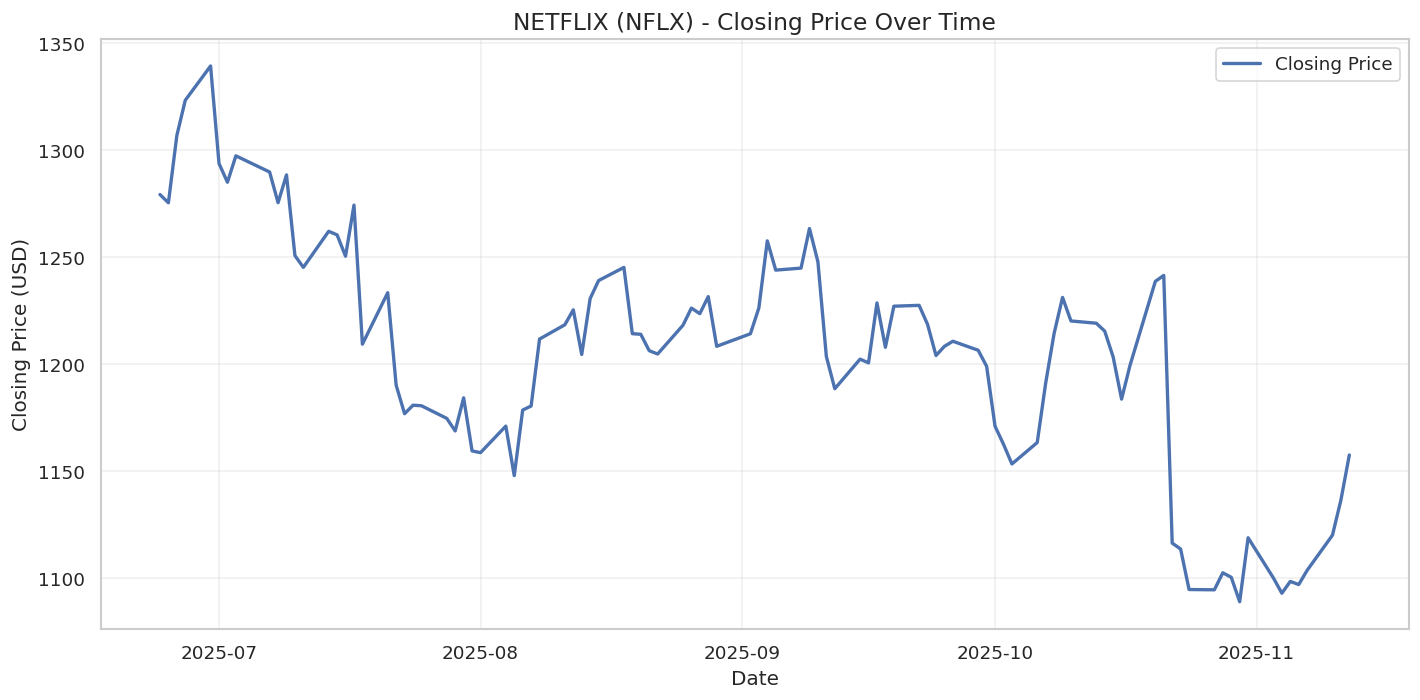

In [69]:
# Ensure data exists
if 'data' in locals() and not data.empty:
  plt.figure(figsize=(12,6))
  plt.plot(data.index, data['4. close'], label='Closing Price', linewidth=2)

  plt.title(f"{company_name} ({symbol}) - Closing Price Over Time", fontsize=14)
  plt.xlabel("Date", fontsize=12)
  plt.ylabel("Closing Price (USD)", fontsize=12)
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()
else:
    print("No data available to visualize. Please run the data fetch cell first.")

In [70]:
import plotly.graph_objects as go
# Ensure data is available
if 'data' in locals() and not data.empty:
    fig = go.Figure(data=[
        go.Candlestick(
            x=data.index,
            open=data['1. open'],
            high=data['2. high'],
            low=data['3. low'],
            close=data['4. close'],
            name=f"{company_name}"
        )
    ])

    fig.update_layout(
        title=f"{company_name} ({symbol}) - Candlestick Chart",
        xaxis_title="Date",
        yaxis_title="Price (USD)",
        xaxis_rangeslider_visible=False,
        template="plotly_white",
        width=950,
        height=550
    )

    fig.show()
else:
    print("No data available to visualize. Please run the data fetch cell first.")


# Sprint 1 Conclusion
**What we achieved in Sprint 1:**

1. Collected real-time open-source data from:


* Wikipedia (summary)
* Yahoo Finance (market prices)
* Google News RSS (recent headlines)
* Generated synthetic tweets (50) for sentiment analysis

2. Cleaned and structured data using **pandas DataFrames**
3. Performed sentiment analysis using **TextBlob**

4. Visualized key insights:
* Sentiment distribution (bar chart)
* Sentiment trend across tweets (line chart)
* Market price trend (line chart)

5. Built a flexible, interactive notebook for any asset/company input

This notebook sets the foundation for Sprint 2, where we will integrate real-time dashboards and AI-driven analytics.

In [71]:
import numpy as np
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [72]:
def card(title, content):
    html = f"""
    <div style='border:1px solid #ddd;border-radius:10px;padding:15px;margin:10px;
                background:beige;font-family:sans-serif;color:black;'>
        <h3 style='text-align:center; color:black'>{title}</h3>
        <p style='line-height:1.5; font-color:white;'>{content}</p>
    </div>
    """
    display(HTML(html))


Headline,Link
"The first 'Netflix House' is open — with virtual reality, mini-golf and lots of selfies - NPR",Read More
"Howard Gordon Talks 'The Beast In Me', Potential '24' Revival: Q&A - Deadline",Read More
Netflix’s The Beast in Me Review - IGN,Read More
"‘The Beast in Me’ Review: Claire Danes and Matthew Rhys Try Hard, but Netflix’s Cat-and-Mouse Thriller Is an Exercise in Prestige TV Monotony - The Hollywood Reporter",Read More
Netflix Pops on Long-Anticipated 10-for-1 Stock Split: Why This Growth Stock Is a Great Buy in November - Yahoo Finance,Read More
There have been 79 new Netflix shows in 2025 so far — here’s the 7 worth watching - Tom's Guide,Read More
Being Eddie' lifts the veil on one of America's top comedians: 9 takeaways from the documentary - Los Angeles Times,Read More
"Eddie Murphy on His Netflix Doc, ‘Shrek 5,’ Resolving Feuds and That Elusive Oscar - The Hollywood Reporter",Read More
Being Eddie review – reverential Netflix doc paints limited portrait of Eddie Murphy - The Guardian,Read More
Sesame Street' on Netflix has these big changes - USA Today,Read More


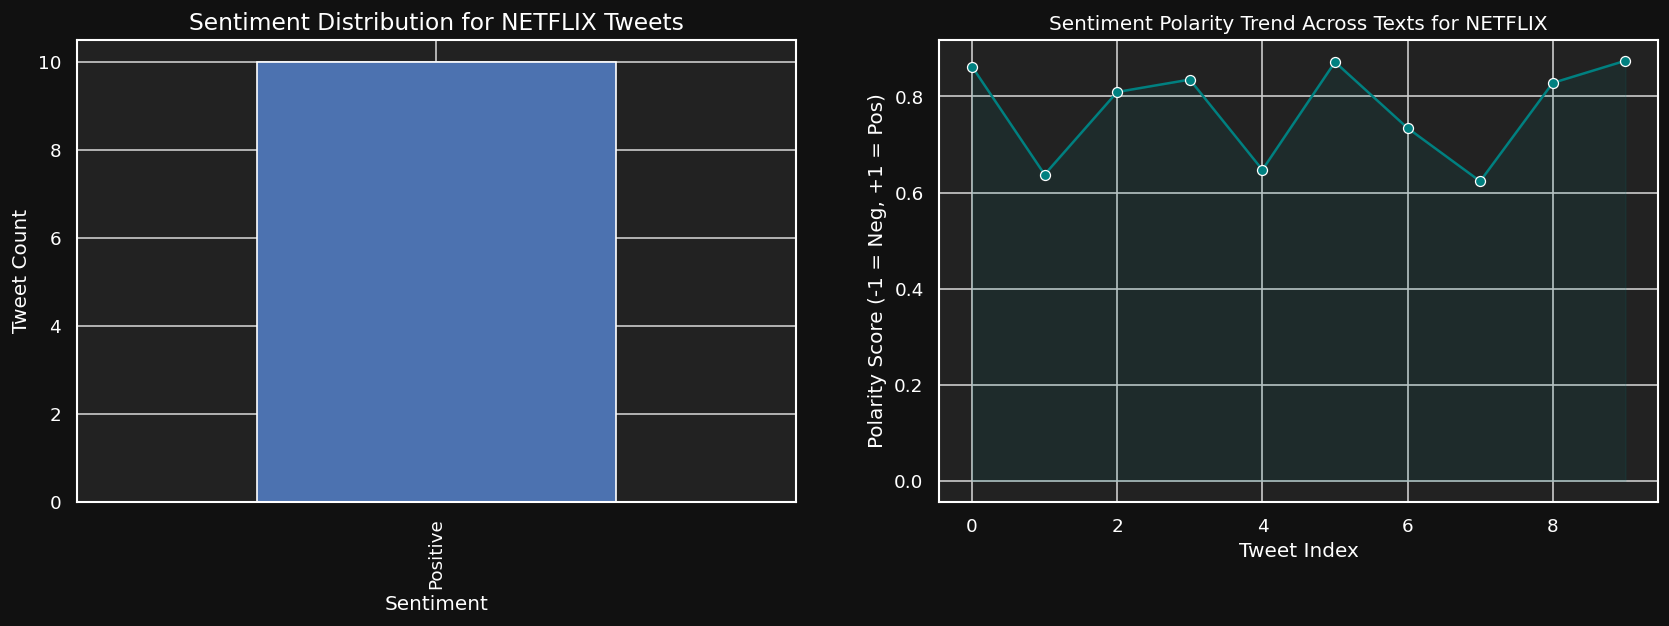

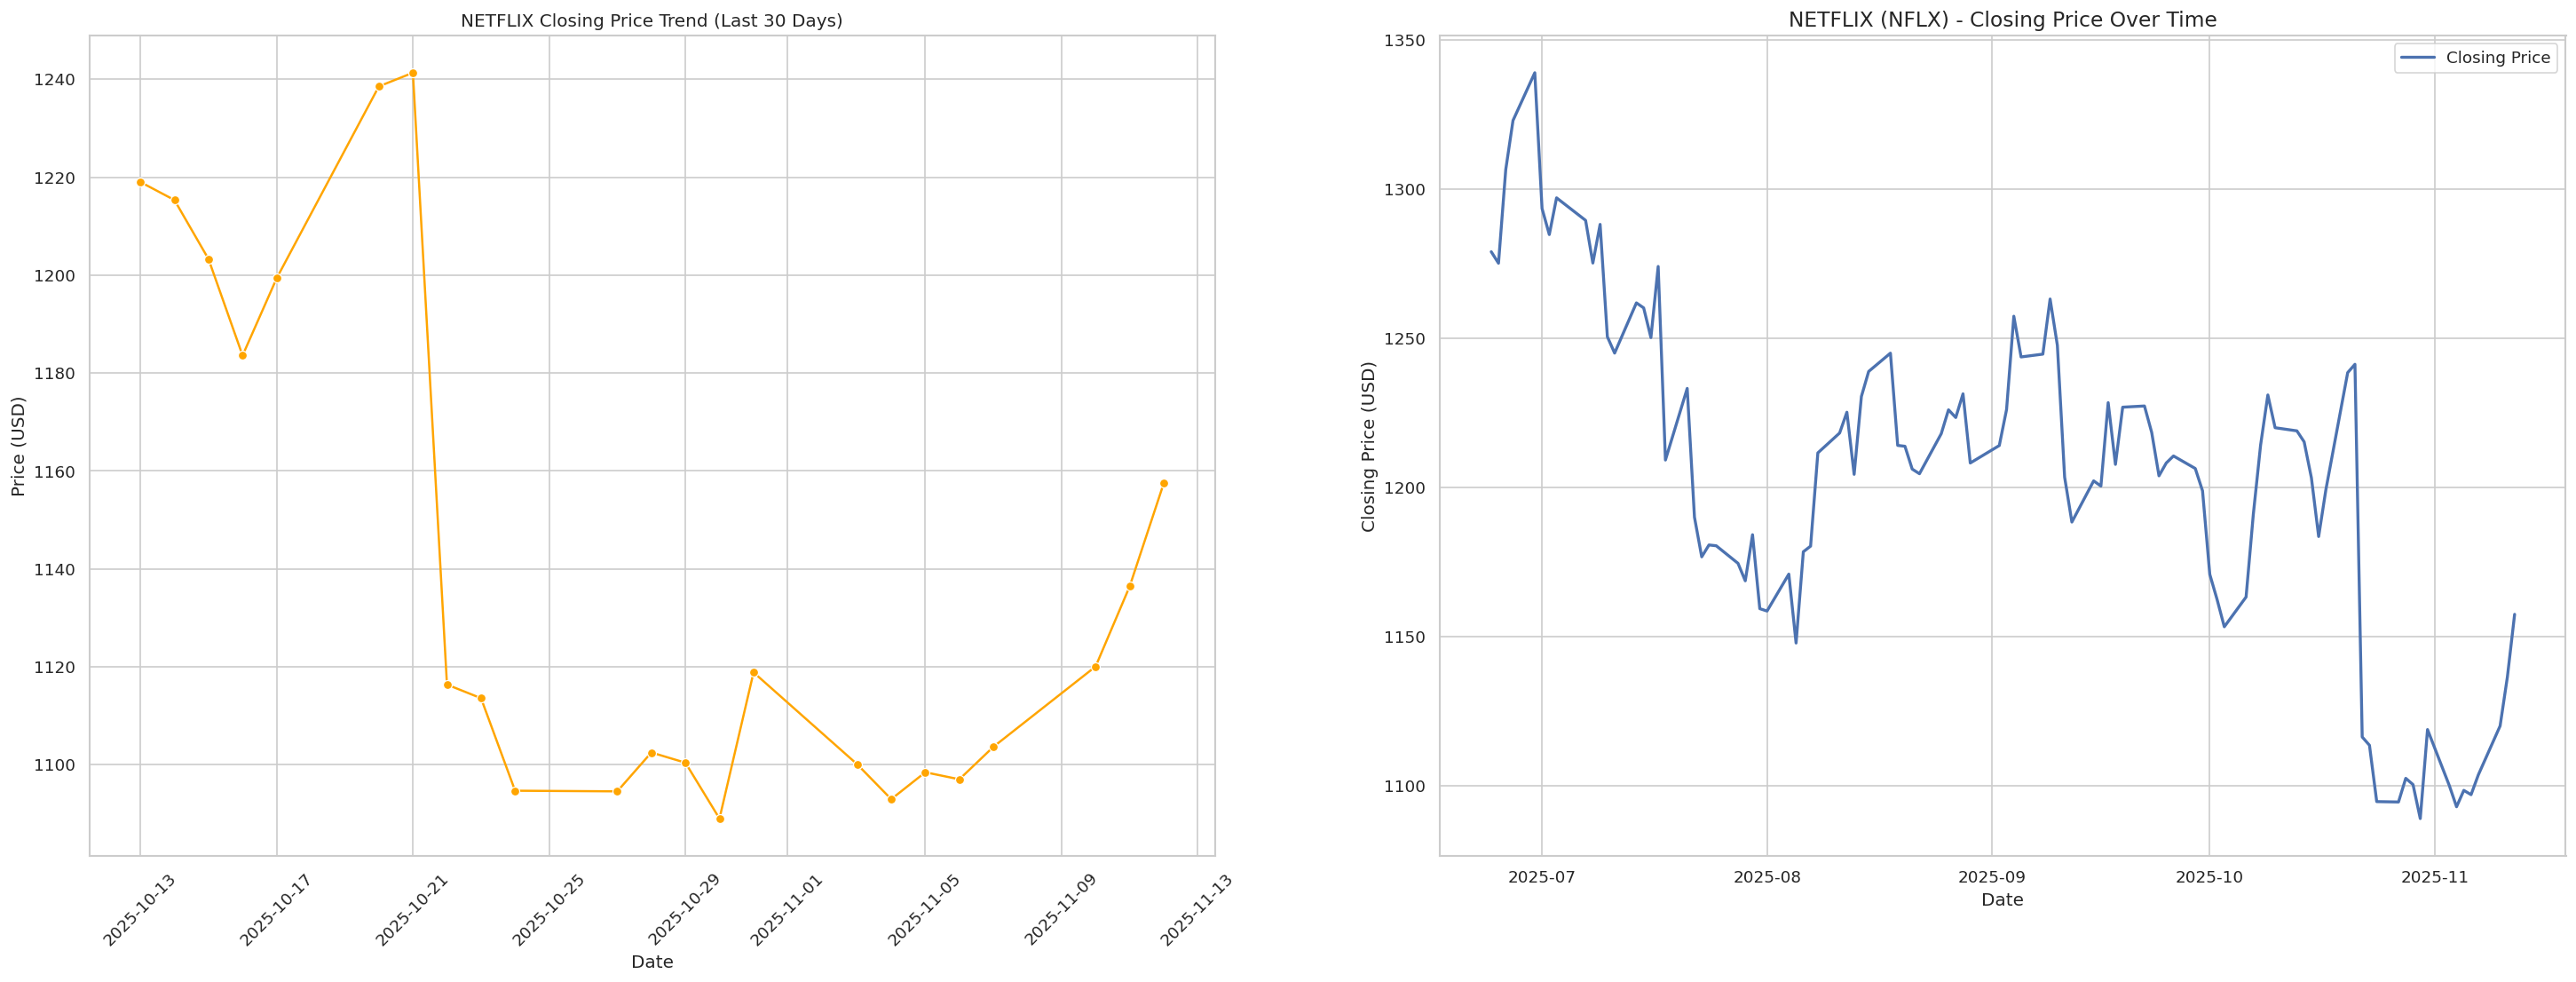

In [77]:
def dashboard(company, summary, analysis_trend, analysis_decision):
  card(company, summary)
  display(HTML(f"<h2 style='font-size:28px; margin-top:25px;'>Top 10 News Headlines for {company}:</h2>"))
  # Remove quotes around titles
  cleaned_titles = [t.strip("'\"") for t in titles]

  # Create a table
  df = pd.DataFrame({
      "Headline": cleaned_titles,
      "Link": [f'<a href="{l}" target="_blank">Read More</a>' for l in links]
  })

  display(HTML(df.to_html(escape=False, index=False)))

  fig, ax = plt.subplots(1,2, figsize=(17,5))

  # sns.countplot(data=tweets_df, x="Sentiment", hue="Sentiment", palette="viridis", legend=False, ax=ax[0])
  # if news_items:
  sent_df['sentiment'].value_counts().plot(kind='bar', edgecolor='white', ax=ax[0])
  ax[0].set_title(f"Sentiment Distribution for {company} Tweets", fontsize=14, color="white")
  ax[0].set_xlabel("Sentiment", color="white")
  ax[0].set_ylabel("Tweet Count", color="white")


  plt.fill_between(
    range(len(sent_df)),
    sent_df["polarity_score"],
    color="teal",
    alpha=0.1
  )
  sns.lineplot(x=sent_df.index, y=sent_df["polarity_score"], marker='o', linestyle='-', color='teal', ax=ax[1])
  ax[1].set_title(f"Sentiment Polarity Trend Across Texts for {company_name}", color="white")
  ax[1].set_xlabel("Tweet Index",  color="white")
  ax[1].set_ylabel("Polarity Score (-1 = Neg, +1 = Pos)",  color="white")
  ax[1].grid(True)

  # --- Apply dark theme to background and all text elements ---
  for a in ax:
      a.set_facecolor("#222")  # axis background
      a.tick_params(colors="white")  # tick label colors
      for spine in a.spines.values():  # axis borders
          spine.set_color("white")

  # --- Figure background ---
  fig.patch.set_facecolor("#111")
  plt.show()

  analysis_text = f"""
  <div style='font-size:15px;'>
    📌 Asset: {company} ({symbol})<br>
    📈 Trend Status: {analysis_trend}<br>
    ✅ Decision: {analysis_decision}
    </div>
    """

  card("AI analysis Summary", analysis_text)



  fig, ax = plt.subplots(1,2, figsize=(30,10))

  sns.lineplot(x=market_data["Date"], y=market_data["Close"], marker='o', color='orange', ax=ax[0])
  ax[0].set_title(f"{company_name} Closing Price Trend (Last 30 Days)")
  ax[0].set_xlabel("Date")
  ax[0].set_ylabel("Price (USD)")
  ax[0].tick_params(axis='x', rotation=45)


  sns.lineplot(x=data.index, y=data['4. close'], label='Closing Price', linewidth=2, ax=ax[1])
  ax[1].set_title(f"{company_name} ({symbol}) - Closing Price Over Time", fontsize=14)
  ax[1].set_xlabel("Date", fontsize=12)
  ax[1].set_ylabel("Closing Price (USD)", fontsize=12)
  plt.grid(True)
  plt.show()

dashboard(company=asset_name, summary=company_summary, analysis_trend=trend, analysis_decision=decision)